This Jupyter Notebook is supposed to run alongside the project repository.

Project contributors:

- HMM model implementation: Oier and Andoni
- Evaluation: Telmo and Solana
- Jupyter Notebook and analysis: Oier, Telmo, Solana and Andoni 

# HMM

An HMM Part-of-Speech (POS) Tagger is a statistical model that assigns parts of speech to words in a sentence using the Hidden Markov Model (HMM) framework.

First we import our model with the needed dependencies:

In [ ]:
from utils.conllu_dataloader import *
from model.hmm import HMMPOSTagger
from utils.visualization_functions import plot_confusion_matrix, plot_f1_scores
import utils.out_of_domain_evaluation as ood_dataloader
import numpy as np
import nltk
nltk.download('universal_tagset')

This are some useful functions to read csv files:

In [ ]:
def csv_to_list_of_lists(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        return [list(row) for row in reader]

def csv_to_list(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        return [row for row in reader][0]

Load datasets and vocabularies

In [ ]:
train_sentences = csv_to_list_of_lists('./datasets/train_dev_sentences.csv')
train_pos_tags = csv_to_list_of_lists('./datasets/train_dev_pos_tags.csv')
vocabulary = csv_to_list('./datasets/train_dev_vocab.csv')

test_sentences = csv_to_list_of_lists('./datasets/test_sentences.csv')
test_pos_tags = csv_to_list_of_lists('./datasets/test_pos_tags.csv')

tags = csv_to_list('./datasets/tagset.csv')

tags.append('*')
tags.append("<STOP>")
vocabulary.append('*')
vocabulary.append("<STOP>")

When we initialize the model we have these parameters:

- `tags`: set of possible tags
- `vocab`: set of possible words



In [ ]:
hmm = HMMPOSTagger(tags, vocabulary)

After initializing we get the following attributes:

- `self.tags2idx` = dictionary to get the idx from the tags
- `self.idx2tags` = dictionary to get the tags from the idx
- `self.tags` = set of used tags
- `self.Q`= number of tags
- `self.vocab` = vocabulary
- `self.transition_counts` = matrix to store the transition counts
- `self.emission_counts` = matrix to store the emission counts
- `self.transition_probs` = matrix to store the transition probabilities
- `self.emission_probs` = matrix to store the emission probabilities
- `self.word_counts` = counter of each word
- `self.tag_counts` = counter of each tag

## CONLLU DATALOADER
Converts conllu files to csv. To do this, we have the `load_dataset` function with this parameter:

- `already_loaded`: If true, skips the function

The function first loads the .conllu files and creates the train and test dataframes. Then, stores parts of these dataframes in these CSVs:

- `tagset.csv`: CSV of all used tags
- `train_dev_vocab.csv`: CSV of the vocab used in the train split
- `test_vocab.csv`: CSV of the vocab used in the test split
- `train_sentences.csv`: CSV of the sentences in train split
- `test_vocab.csv`: CSV of the sentences in test split
- `train_dev_pos_tags.csv`: CSV of the PoS tags of the sentences in train split
- `test_pos_tags.csv`: CSV of the PoS tags of the sentences in test split





In [ ]:
from utils.conllu_dataloader import load_datasets
load_datasets()

## TRAIN FUNCTION

Function to train our HMM model

Our train function has the following parameters:
- `sentences`
list of all the sentences in our train dataset
- `pos_tags`
list of all the PoS tags of the sentences in our train dataset
- `change_vocab` if true, it updates the vocab by removing the least frequent words and turning them all to `<UNK>`

First the model counts the occurrences of the tags and the words and stores them in two dictionaries.
The first one is "transition_counts" where we store each tags that follows another tag; and the second one is "emission_counts" where we store each word associated with a tag.
We also take into account the number of occurrences of each tag and word, and we store them in "tag_counts" and "word_counts" respectively.

Every time we start a new sentence we insert a "*" in the first position and a `<STOP>` in the last position. This is to take into consideration the first and last words of a sentence.

After running all the sentences we check if we have to change the vocabulary. If so, we revise the words in dictionary "word_counts", we remove the words that appear less than 5 times and we add the counts to the `<UNK>` token. We do this so that the model can work better with unknown words.

Then, to sample with the model, we have to get the probabilities of transitions and emission counts. This is achieved with the following function:
$$
P(q_i|q_{i-1})={count(q_{i-1},q_i) \over count(q_{i-1})}
$$

Where $ q_{i-1} $ are going to be the previous tags and $ q_i $ the current tags in transition counts, and with emission counts, the $ q_{i-1} $ are going to be the current words and the $q_i$ are going to be the current tags.


After running the train function we will have two matrices:
 1) transition probabilty matrix
 2) emission probabilty matrix

We can train the model using the following code:

In [ ]:
hmm.train(train_sentences, train_pos_tags, change_vocab = True)

If we want to inspect the transition and emission probabilities we can check them like this (The output is very long):

In [ ]:
print(f'The transition probability matrix: {hmm.transition_probs.items()}\n\n')
print(f'The emission probability matrix: {hmm.emission_probs.items()}')

## VITERBI ALGORITHM

This algorithm determines what PoS tags a sentence contains using the HMM that we have trained.
The parameter that we use here is:
- `sentence`: the sentence we have to predict the PoS tags of


First, we take a look at the sentence and we search each word in the vocabulary. If there is no such word in the vocabulary we replace it with the `<UNK>` token.
Next, we apply the algorithm. To do that, we define two variables: the viterbi matrix, where we will store the probabilities; and the backpointer, where we store the most probable path. At this point we calculate the probabilty of the word for each tag with the following function: $$viterbi[q,t]=\max viterbi[q',t-1]*A_{[q',q]}*B_{[q,t]}$$

Where $A$ is the transition matrix and $B$ the mission matrix. Also the $q$ is the current tag and t is the current word of the sentence.

The $q'$ that gets the maximum pobabilty is stored in the backpointer. This way the viterbi function gives back the  initial sentence and the PoS tags predicted by the algorithm.

In [ ]:
sentence = ['Jeremy','loves','NLP']
hmm.viterbi_alg(sentence)

['PROPN', 'VERB', 'NOUN']

## EVALUATE FUNCTION

This function evaluates the test dataset with Viterbi and, with whatever Viterbi returns, we calculate accuracy and F1.

In [ ]:
test = [['Jeremy', 'Loves', 'NLP'],
        ['How', 'do', 'people', 'live', 'in', 'houses'],
        ['Those','in', 'power', 'have', 'little', 'interest', 'in', 'education']
]
tags = [['PROPN', 'VERB', 'NOUN'],
        ['ADV', 'VERB', 'NOUN', 'VERB', 'ADP', 'NOUN'],
        ['PRON', 'ADP', 'NOUN', 'VERB', 'ADJ', 'NOUN', 'ADP', 'NOUN']]

acc, cm, unique_tags, precision, recall, f1 = hmm.evaluate(test, tags, mapping_mode = "in_domain_mapping")
print(f'Accuracy: {acc}')
print(f'CM: {cm}')
print(f'Unique_tags: {unique_tags}')
print(f'Precision {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

Evaluating...
Accuracy: 1.0
CM: [[1 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 7 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 4]]
Unique_tags: ['ADJ', 'ADP', 'ADV', 'NOUN', 'PRON', 'VERB']
Precision [1. 1. 1. 1. 1. 1.]
Recall: [1. 1. 1. 1. 1. 1.]
F1: [1. 1. 1. 1. 1. 1.]


# EVALUATION AND ANALYSIS

We have decided to evaluate our model in both "in_domain" and "out_of_domain" scenarios and we have also decided to add the chance to map the PoS tags to match the NLTK PoS tagset. This would be the mapping:

- CONJ <- SCONJ, CCONJ
- VERB <- VERB + AUX
- NOUN <- NOUN + PROPN
- . <- PUNCT + SYM
- PRT <- PART

So, in the following cells we will evaluate and analyze the following:

- In domain using UD PoS tags
- In domain using UD PoS tags with our approach
- In domain with tags mapped to NLTK PoS tags
- Out of domain with tags mapped to NLTK PoS tags

First we load all the needed data:

In [ ]:
train_sentences = csv_to_list_of_lists('./datasets/train_dev_sentences.csv')
train_pos_tags = csv_to_list_of_lists('./datasets/train_dev_pos_tags.csv')
vocabulary = csv_to_list('./datasets/train_dev_vocab.csv')

test_sentences = csv_to_list_of_lists('./datasets/test_sentences.csv')
test_pos_tags = csv_to_list_of_lists('./datasets/test_pos_tags.csv')

tags = csv_to_list('./datasets/tagset.csv')

# To mark the beginning and the ending of the sentences we will use '*' and '<STOP>' strings
tags.append('*')
tags.append("<STOP>")
vocabulary.append('*')
vocabulary.append("<STOP>")

ood_test_sentences, ood_test_tags = ood_dataloader.ptb_dataloader()

Then we train two HMM models with the training data, one with `change_vocab=False`, which is our approach to `<UNK>` token usage, and the other one with `change_vocab=True` which follows the implementation from the slides:

In [ ]:
hmm_ours = HMMPOSTagger(tags, vocabulary)
hmm = HMMPOSTagger(tags, vocabulary)

hmm_ours.train(train_sentences, train_pos_tags, change_vocab=False)
hmm.train(train_sentences, train_pos_tags, change_vocab=True)

## In-Domain without re-mapping

We will use UD annotated sentences to both train and test the HMM.

First we will load the train and test datasets from the csv files:

In [ ]:
print("\n\n\033[1mIn-Domain with no re-mapping\033[0m (Original Universal Dependencies tags):")
acc1, cm1, ut1, precision1, recall1, fscore1  = hmm.evaluate(test_sentences, test_pos_tags, mapping_mode="in_domain_no_mapping")
print(f" - Test accuracy: {acc1}")
print(f" - Test precision : {np.mean(precision1)}")
print(f" - Test recall: {np.mean(recall1)}")
print(f" - Test f1-score: {np.mean(fscore1)}")
plot_confusion_matrix(cm1, ut1, title="In-Domain PoS Tagging Confusion Matrix", do_plot=False)
plot_f1_scores(ut1, precision1, recall1, fscore1, title="In-Domain Precision, Recall and F1-Scores for Each PoS Tag", do_plot=False)



In-Domain with no re-mapping (Original Universal Dependencies tags):
Evaluating...
 - Test accuracy: 0.8692148469685095
 - Test precision : 0.8141399678245254
 - Test recall: 0.8085172380558725
 - Test f1-score: 0.8036159770380396


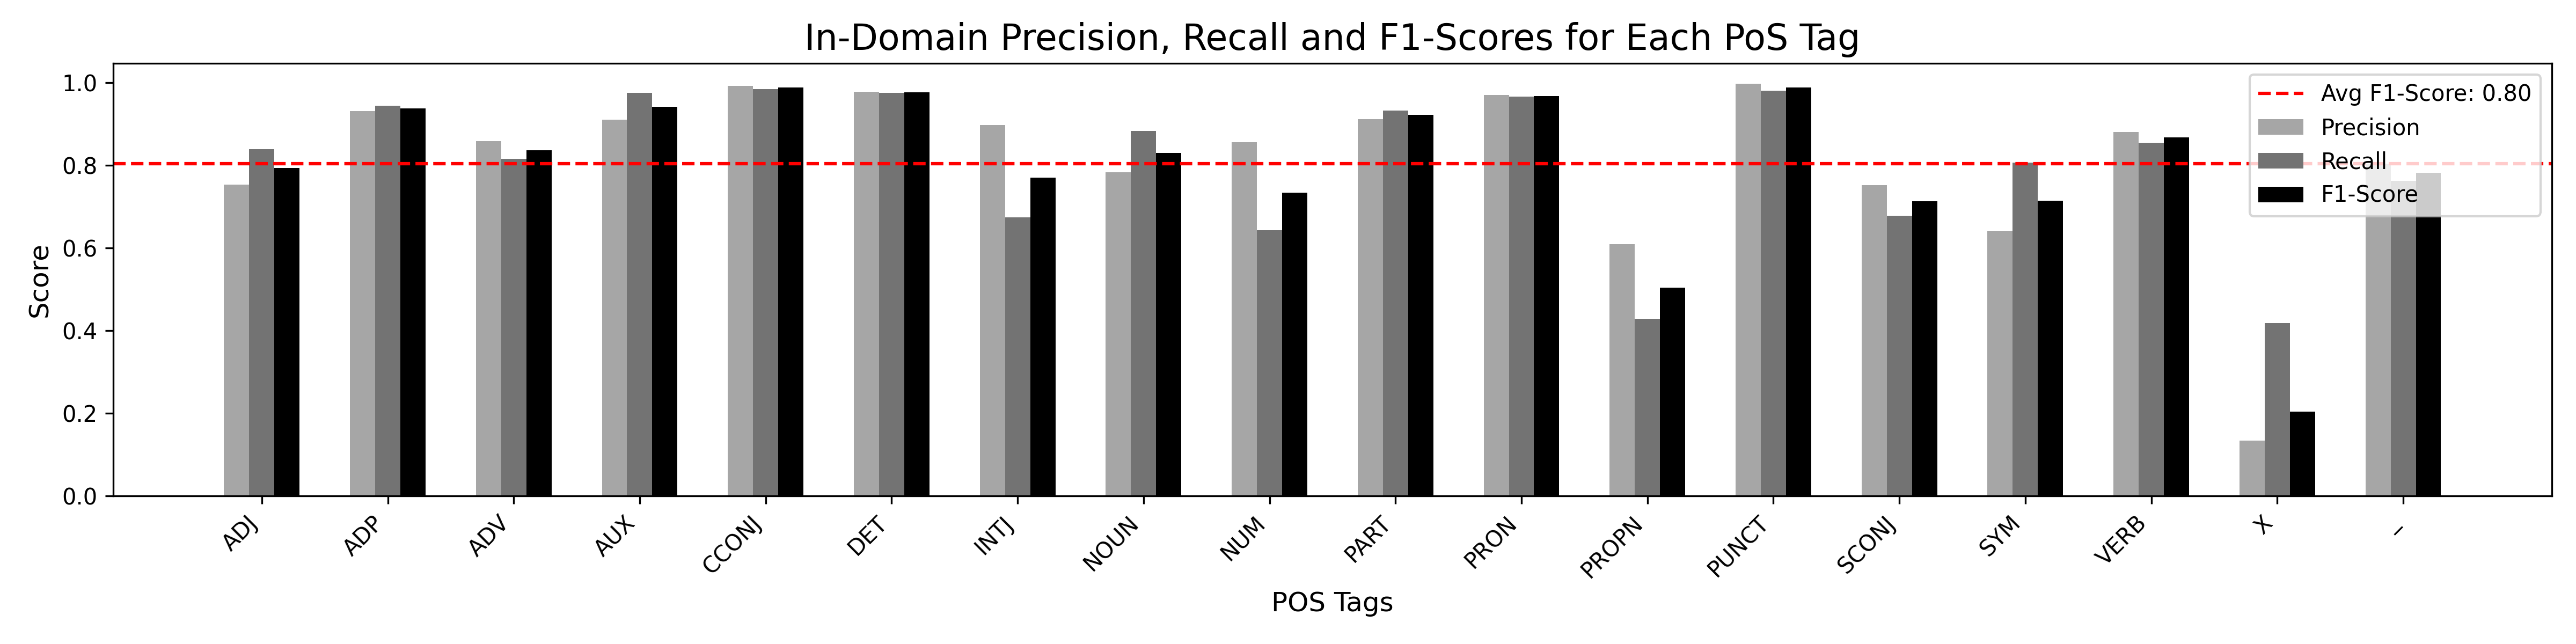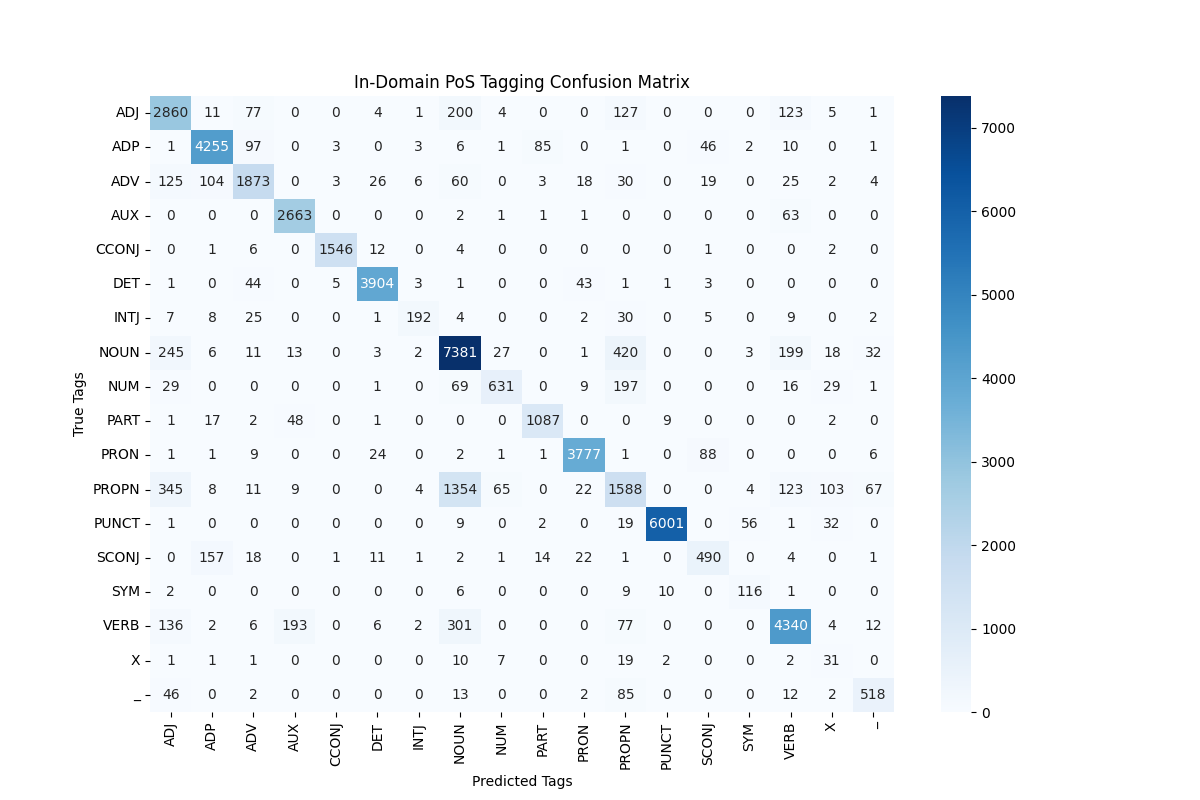

## In-Domain without re-mapping our approach

We will use UD annotated sentences to both train and test the HMM.

First we will load the train and test datasets from the csv files:

In [ ]:
print("\n\n\033[1mIn-Domain with no re-mapping\033[0m (Original Universal Dependencies tags):")
acc1, cm1, ut1, precision1, recall1, fscore1  = hmm_ours.evaluate(test_sentences, test_pos_tags, mapping_mode="in_domain_no_mapping")
print(f" - Test accuracy: {acc1}")
print(f" - Test precision : {np.mean(precision1)}")
print(f" - Test recall: {np.mean(recall1)}")
print(f" - Test f1-score: {np.mean(fscore1)}")
plot_confusion_matrix(cm1, ut1, title="In-Domain PoS Tagging Confusion Matrix our Approach", do_plot=False)
plot_f1_scores(ut1, precision1, recall1, fscore1, title="In-Domain Precision, Recall and F1-Scores for Each PoS Tag our Approach", do_plot=False)



In-Domain with no re-mapping (Original Universal Dependencies tags):
Evaluating...
 - Test accuracy: 0.8647535218343683
 - Test precision : 0.8288854475295737
 - Test recall: 0.8057533860836905
 - Test f1-score: 0.7973838320276985


Don't click the image :)

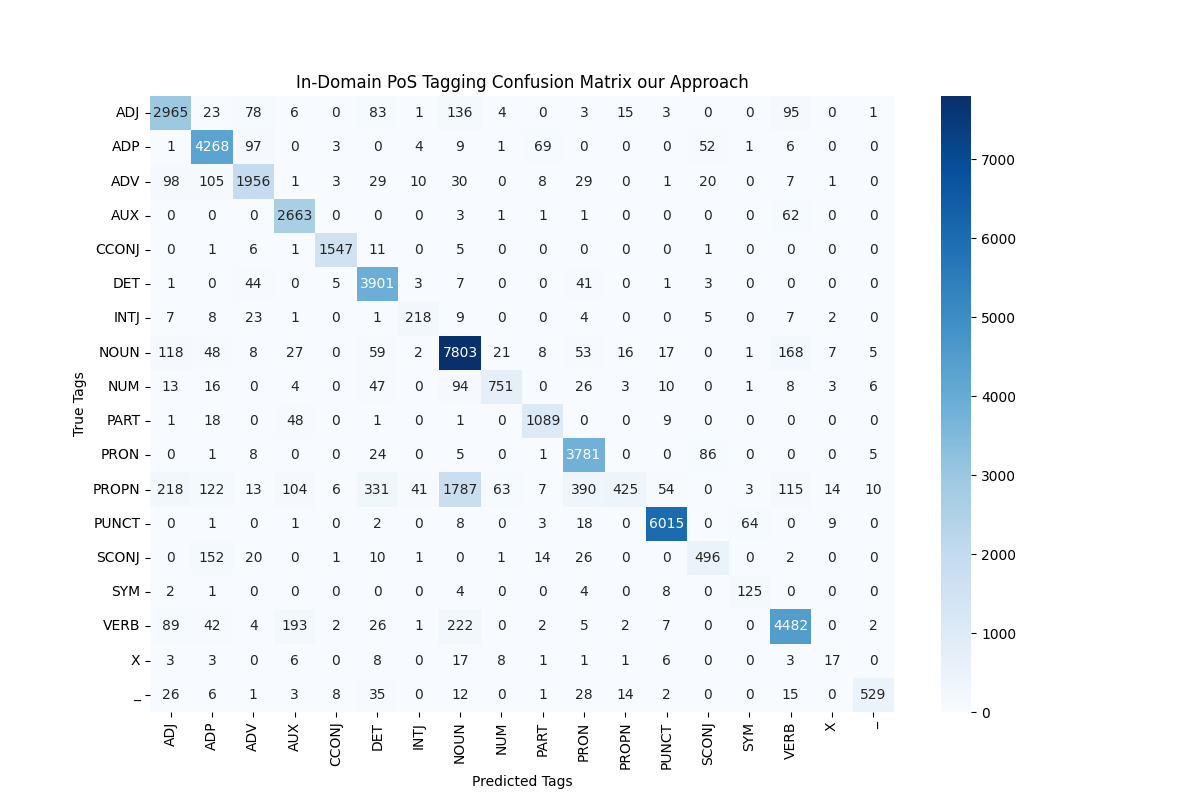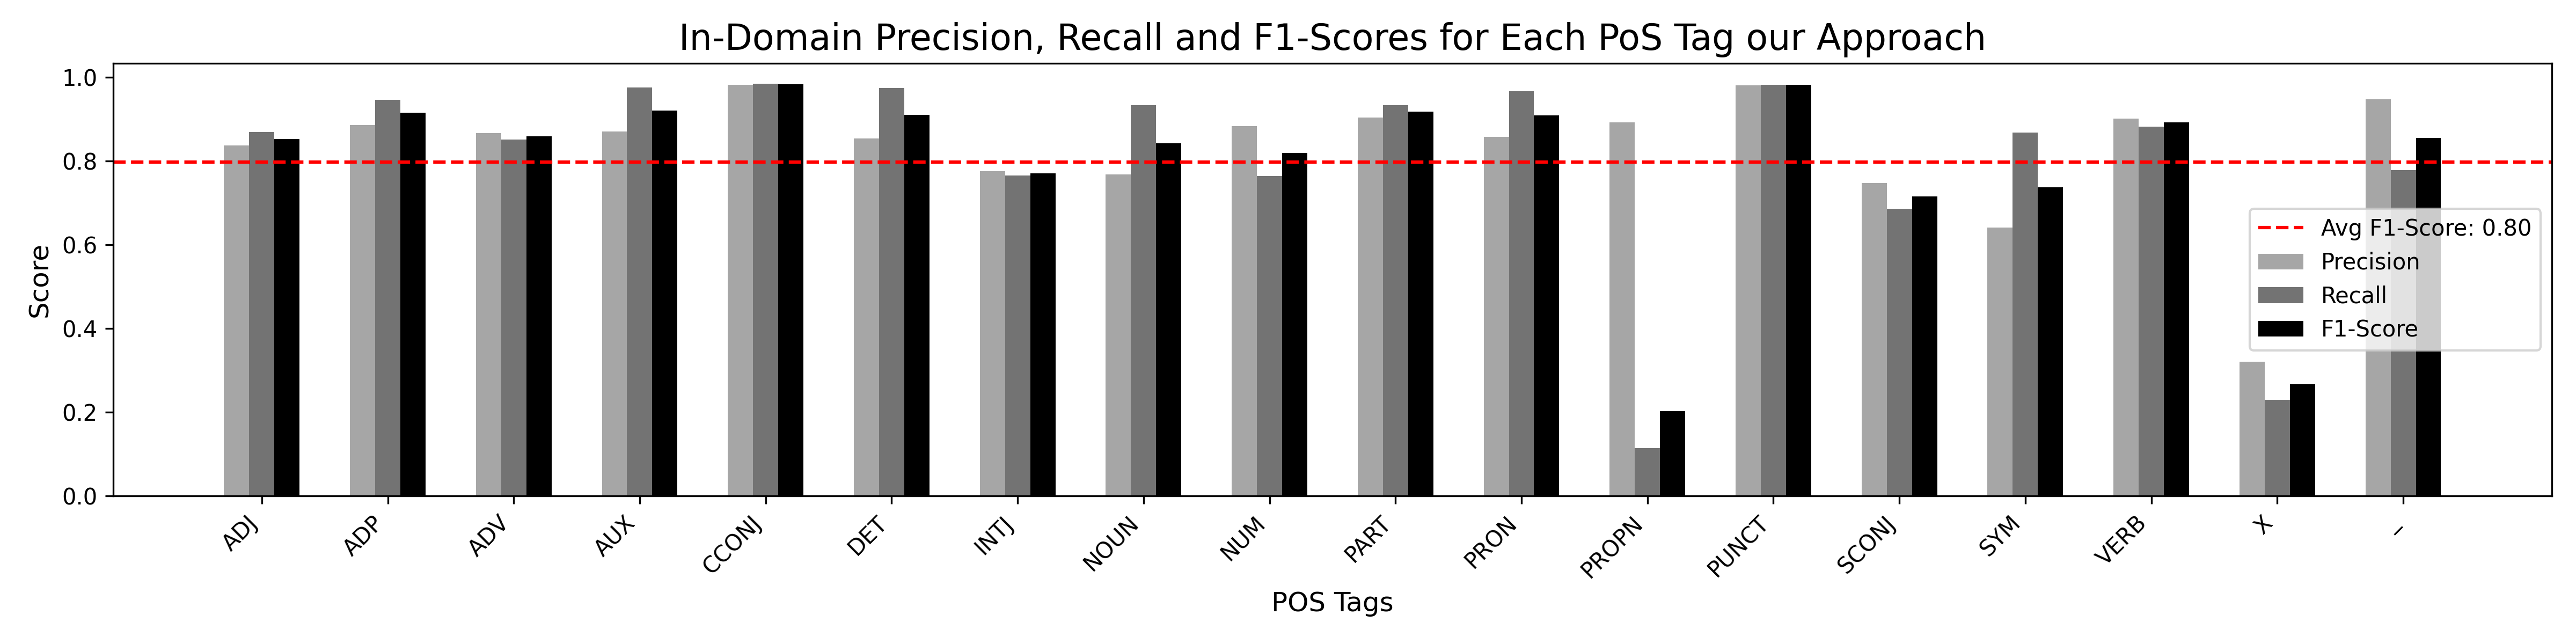

## In-Domain with re-mapping

We will use UD annotated sentences to both train and test the HMM.

First we will load the train and test datasets from the csv files:

In [ ]:
print("\n\033[1mIn-Domain with re-mapped PoS tags\033[0m (NLTK universal tags):")
acc2, cm2, ut2, precision2, recall2, fscore2 = hmm.evaluate(test_sentences, test_pos_tags, mapping_mode="in_domain_mapping")
print(f" - Test accuracy: {acc2}")
print(f" - Test precision : {np.mean(precision2)}")
print(f" - Test recall: {np.mean(recall2)}")
print(f" - Test f1-score: {np.mean(fscore2)}")
plot_confusion_matrix(cm2, ut2, title="In-Domain Re-Mapped PoS Tagging Confusion Matrix", do_plot=False)
plot_f1_scores(ut2, precision2, recall2, fscore2, title="In-Domain Precision, Recall and F1-Scores for Each Re-Mapped PoS Tag", do_plot=False)


In-Domain with re-mapped PoS tags (NLTK universal tags):
Evaluating...
 - Test accuracy: 0.91137637909206
 - Test precision : 0.844712119998194
 - Test recall: 0.8328439879874053
 - Test f1-score: 0.8310784618464115


/Volumes/MacOS 1TB/Repos/hmm_pos_tagger/utils/visualization_functions.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 8))
/Volumes/MacOS 1TB/Repos/hmm_pos_tagger/utils/visualization_functions.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/Volumes/MacOS 1TB/Repos/hmm_pos_tagger/utils/visualization_functions.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


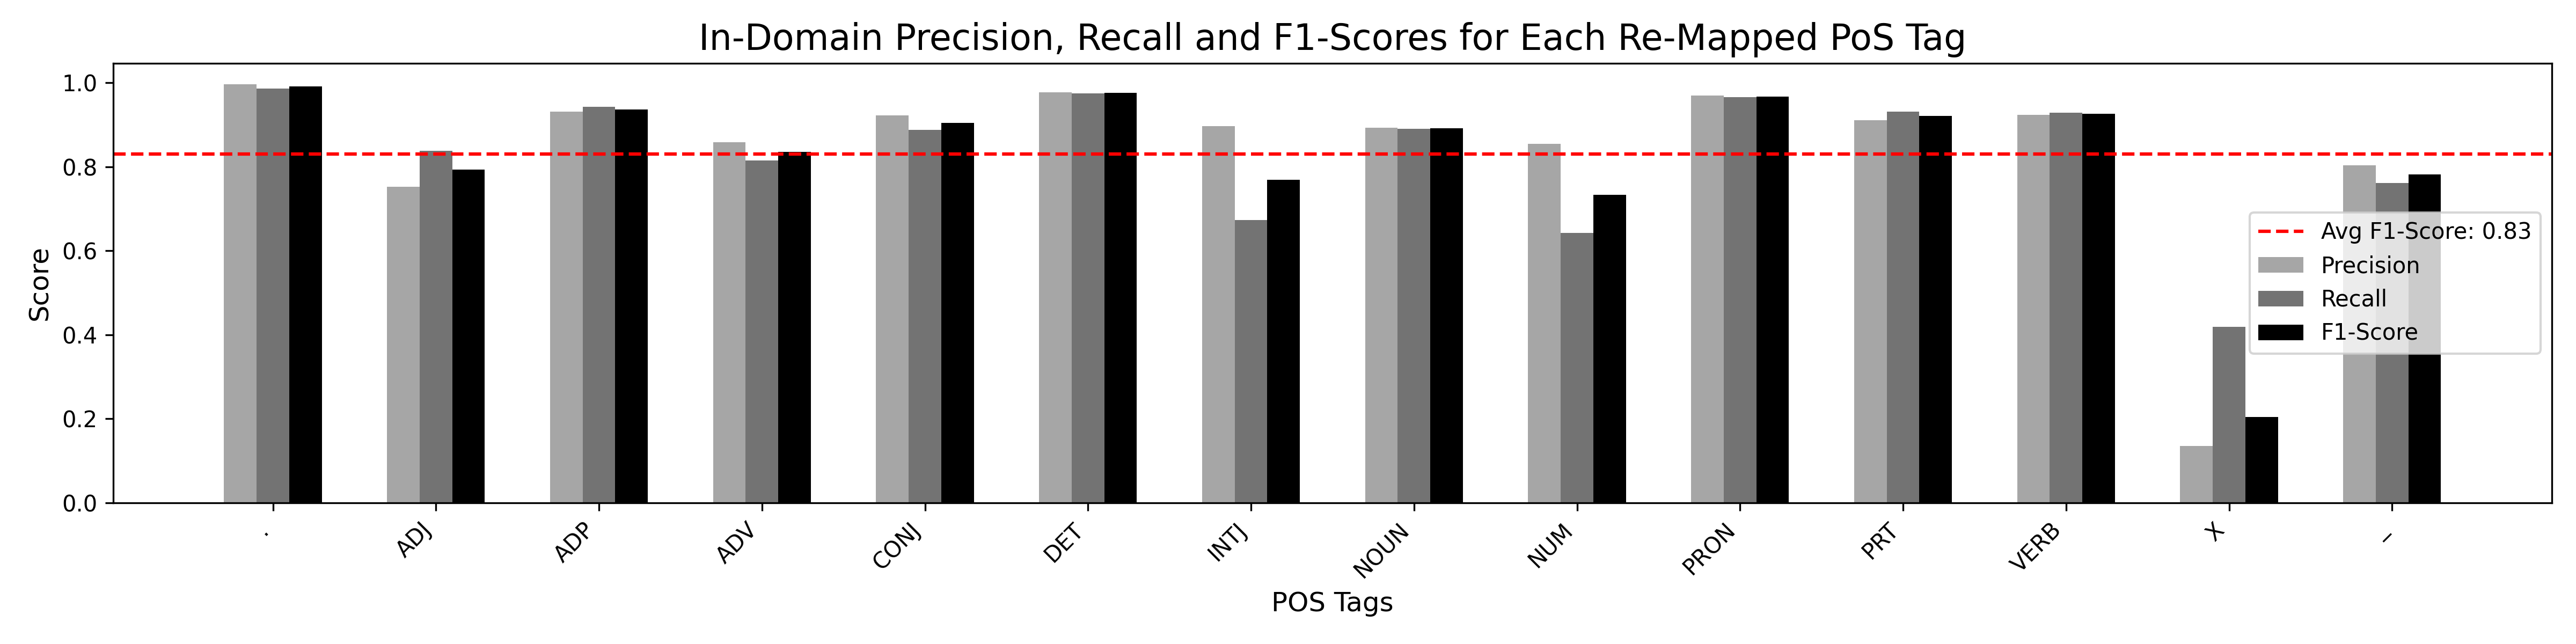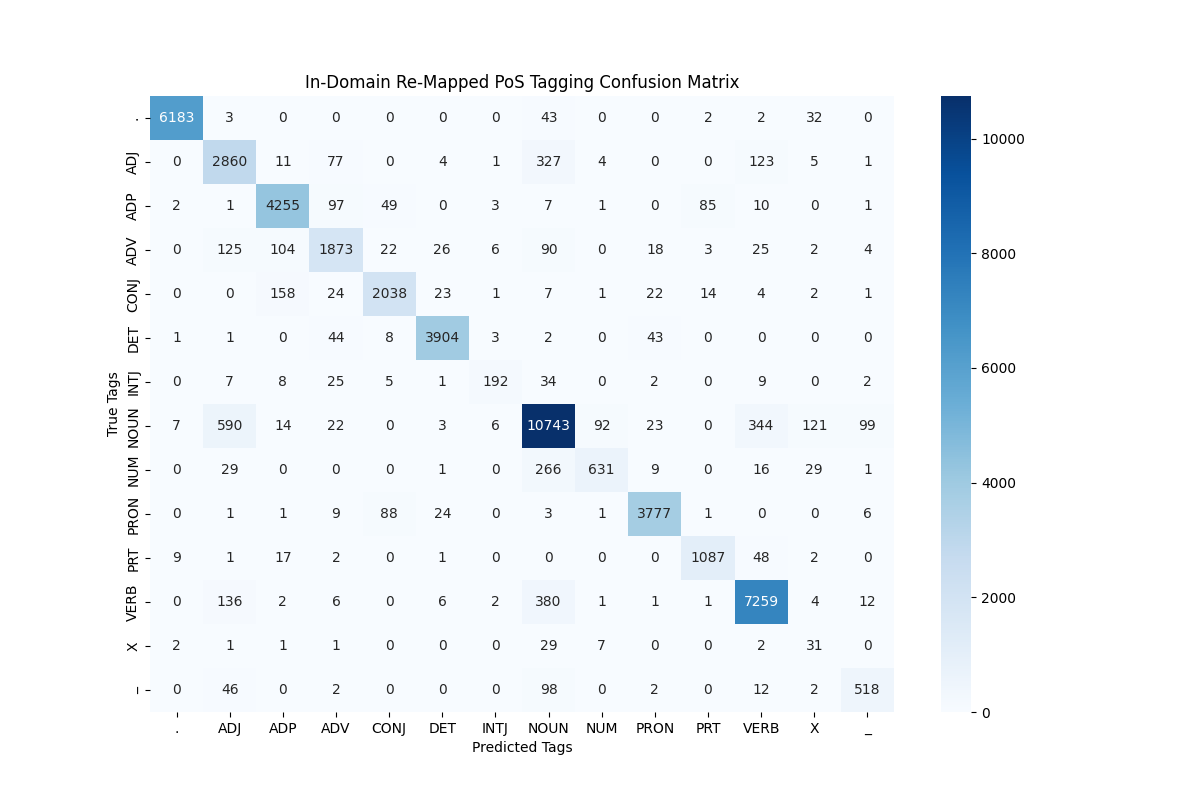

## Out-Of-Domain

In [ ]:
print("\n\n\033[1mOut-of-Domain with re-mapped PoS tags\033[0m (NLTK universal tags):")
acc3, cm3, ut3, precision3, recall3, fscore3  = hmm_ours.evaluate(ood_test_sentences, ood_test_tags, mapping_mode="out_domain_mapping")
print(f" - Test accuracy: {acc3}")
print(f" - Test precision : {np.mean(precision3)}")
print(f" - Test recall: {np.mean(recall3)}")
print(f" - Test f1-score: {np.mean(fscore3)}")
plot_confusion_matrix(cm3, ut3, title="Out-of-Domain PoS Tagging Confusion Matrix", do_plot=False)
plot_f1_scores(ut3, precision3, recall3, fscore3, title="Out-of-Domain Precision, Recall and F1-Scores for Each PoS Tag", do_plot=False)



Out-of-Domain with re-mapped PoS tags (NLTK universal tags):
Evaluating...


/Volumes/MacOS 1TB/Repos/hmm_pos_tagger/my_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 - Test accuracy: 0.7897314156303389
 - Test precision : 0.5887642574461859
 - Test recall: 0.6658673204093389
 - Test f1-score: 0.6173688732100138


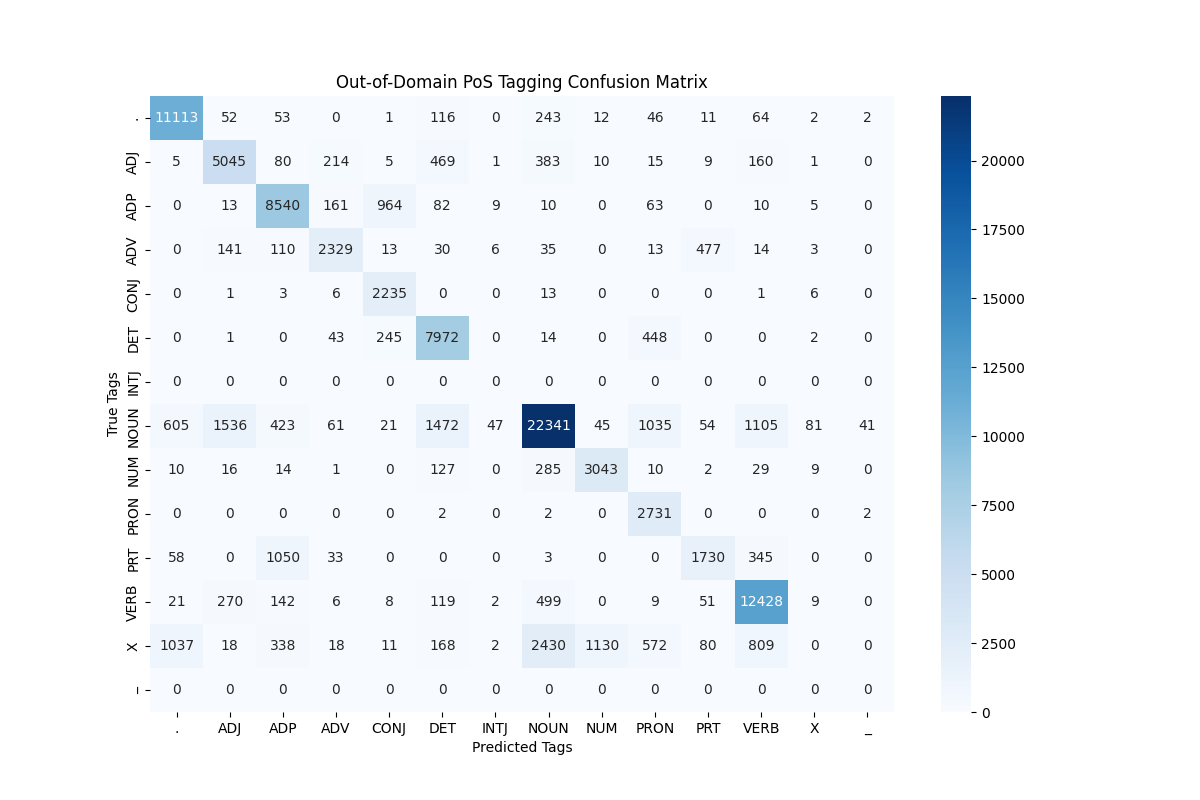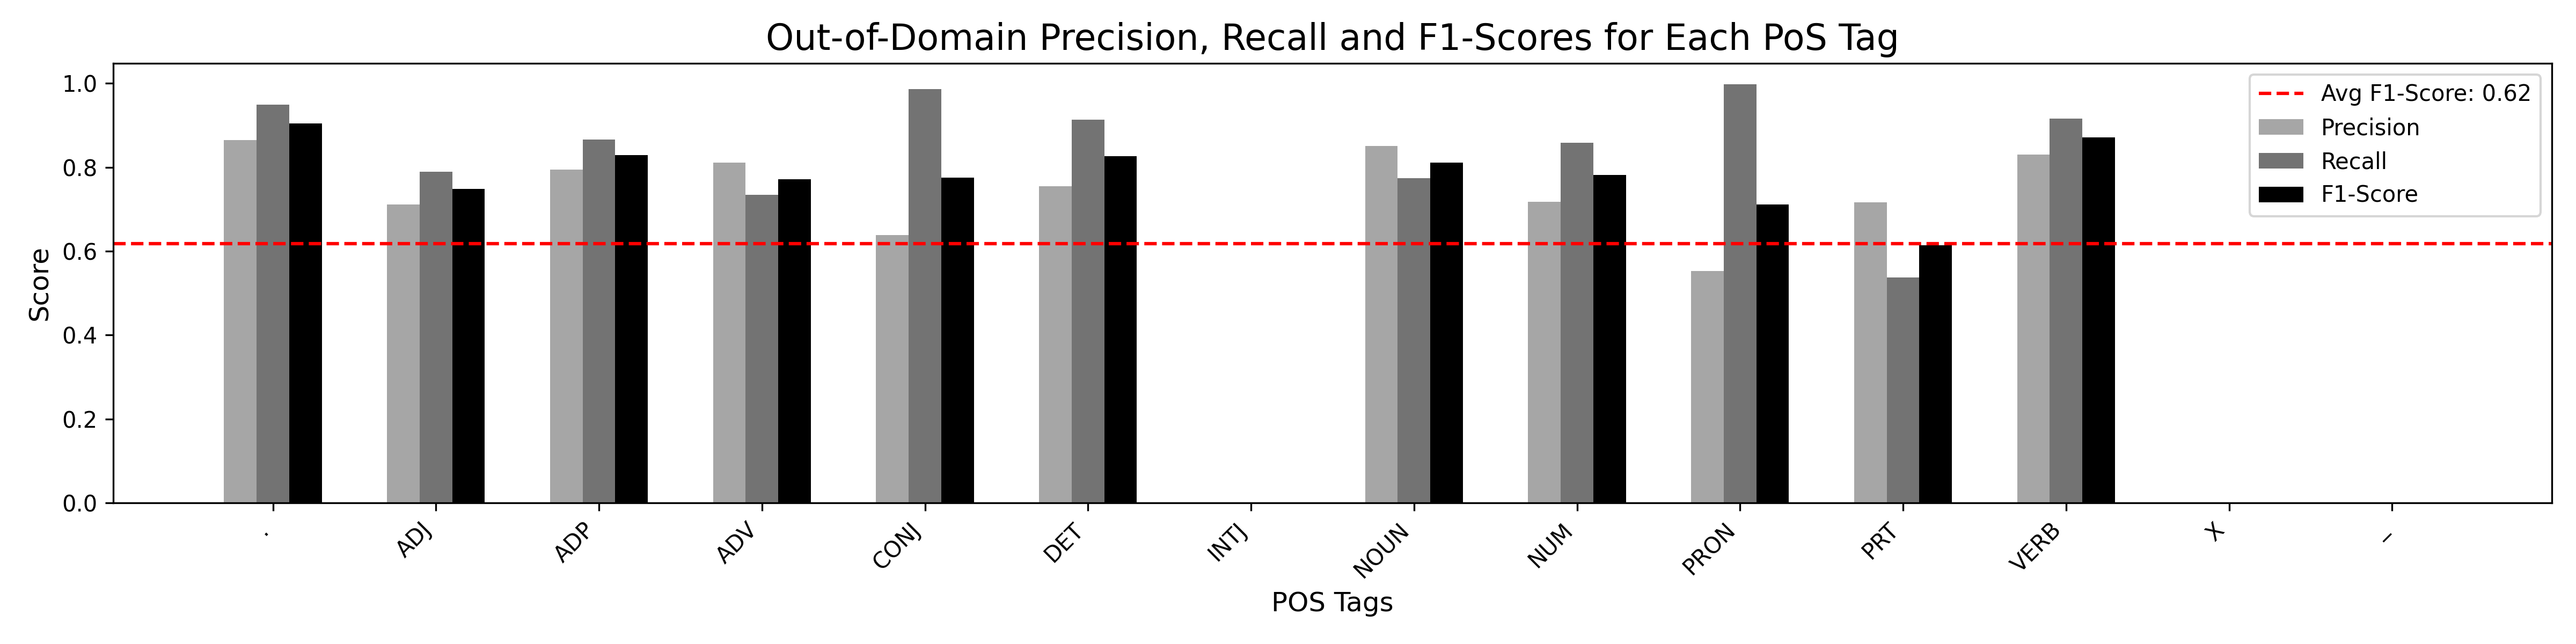

# ANALYSIS AND CONCLUSIONS


We have implemented the Hidden Markov Model with a train function and Viterbi algorithm to sample from the model using Transition and Emission probability matrices.

- Our approach of handling UNK tokens performs similarly compared to the one explained in the slides. The gap between these two implementations is very small, so we opted to use the approach from the slides for further analysis.
- The results show us that our approach of handling UNK tokens is at par with the one in the slides.
- We can see that both approaches perform quite well on in-domain scenarios, with the approaches getting a 0.80 average f1-score.
- When the mapping is not applied, both approaches tend to have problems with Proper Nouns and Nouns. The slides approach predicts 1354 Proper Nouns as Nouns and, our approach, 1787 Proper Nouns as Nouns. This confusion in the models is expected, as both of them are Nouns in the end.
- We can also see that the models tend not to have a very good performance in unusual PoS tags such as SYM. One reason for this could be that the model has not seen enough examples of these PoS tags while training.
- We mapped the UD PoS tags to the NLTK PoS tags and tried out the in-domain scenario once more. This time, we got a f1-score of 0.83. One of the reasons for that could be the decrease in the number of PoS tags from 18 to 14.
- When out-of-domain, the model descreases its performance to 0.62. This decrease is expected, as out-of-domain scenarios are harder than the in-domain ones.
- The model in out-of-domain scenarios, even if the PoS tags are mapped, some non-ordinary tags, such as "X" or "_", don't perform very well.
- One clear conclusion here is that our model is not able to generalize efficiently to out-of-domain data with new PoS tags. Another reason for that could be that the datasets used for training and testing contain very different topics.